-------------------------------------------------------------------------------------------------------------------
Implementation of : "Online Label Recovery for Deep Learning-based communication through Error Correcting codes"

Author : Eric Soubigou

Date : Spring 2019

-------------------------------------------------------------------------------------------------------------------

Description :  Creation of a DFE like with Deep Learning technologies

In [1]:
# Install libraries :
!pip3 install --user --upgrade pip
!pip3 install --user scipy matplotlib matplotlib2tikz torch
!pip3 install --user git+git://github.com/veeresht/CommPy.git@master
print("================== DONE ! ==================")

Requirement already up-to-date: pip in /home/eric/.local/lib/python3.6/site-packages (19.1.1)
  Cloning git://github.com/veeresht/CommPy.git (to revision master) to /tmp/pip-req-build-i_f2qhcu
  Running command git clone -q git://github.com/veeresht/CommPy.git /tmp/pip-req-build-i_f2qhcu
  Stored in directory: /tmp/pip-ephem-wheel-cache-wctnw_wm/wheels/d1/6a/31/8ddc70e8eb8a1c3ad344032ed43b4ebfccc41007e8850226d0
Successfully built scikit-commpy
================== DONE ! ==================


In [1]:
## Imports
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function

# Numpy
import numpy as np
np.set_printoptions(precision=2)

# For DL libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set the use of device which will be used 
if torch.cuda.is_available():
    device = torch.device('cuda')
    FloatTensor = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    FloatTensor = torch.FloatTensor


In [ ]:
# Launch simulation
from MonteCarlo import *

simulation_param_dict = {
    "m_c_parameters": {
        "min_error_frame": 100,
        "targeted_fer": 1e-2,
        "step_db": 2,
        "min_eb_n0": 0,
        "max_eb_n0": 50,
    },
    "channel_parameters": {
        "channel_type": "Proakis_C",
        "non_lin_coeff": 0,
        "iq_imbalance": None,
        "channel_taps": np.array([1, 2, 3, 2, 1]),
    },
    "frame_length": 256,
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
    "pre_equalizer": {
        "model_path": None,
        "feed_back_freq": 0,
    }
}

# Launch the simulation
monte_carlo_simulation(simulation_param_dict)

In [5]:
from DataSetManager import *

# Data set Creation
data_set_generation_param_dict = {
    "eb_n0_db": 10,
    "channel_parameters": {
        "channel_type": "AWGN",
        "non_lin_coeff": 0.5,
        "iq_imbalance": 0.5,
        "channel_taps": np.array([1]),
    },
    "frame_length": 6000060,#2000140, # 1000040
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
}

create_data_set(data_set_generation_param_dict)

shape comparison samples and targets (105470, 72) (105470, 72)
Data set created at ./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_10_proakis_C.pt


In [ ]:
#  Train the NN-prequlizer
from PreEqualizer import *
from DataSetManager import *
from torch.utils.data import DataLoader

# Load the data set
data_set = OFDMSamplesDataset(
    "./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_10_proakis_C.pt"
)
# Spliting policies
training_size = int(0.8 * len(data_set))
validation_size = int(0.1 * len(data_set))
test_size = int(0.1 * len(data_set))

print(
    "Splitting of data set: \n\tTraining set size : {}/{} \n\tValidation set size : {}/{} \n\tValidation test size : {}/{}\n".format(
        str(training_size),
        str(len(data_set)),
        str(validation_size),
        str(len(data_set)),
        str(test_size),
        str(len(data_set)),
    )
)

# Split data set
training_set, validation_set, test_set = torch.utils.data.random_split(
    data_set, [training_size, validation_size, test_size]
)

# Create a data loaders...
batch_size_set = 10000
nb_epochs = 500

training_dataloader = DataLoader(
    dataset=training_set, batch_size=batch_size_set, shuffle=False
)
validation_dataloader = DataLoader(
    dataset=validation_set, batch_size=batch_size_set, shuffle=False
)

# Creation of the PreEqualizer
model_path = "./models/pre_eq_model.pth"
path_training = "./models/pre_eq_model_training_perf.pickle"

pre_eq = PreEqualizer(data_set.get_number_of_carriers())

try:
    pre_eq.load_state_dict(torch.load(model_path))
except:
    print("Can't load {} => Generate a new model\n".format(model_path))

# Train the Pre-Equalizer in standalone mode
PreEqualizer.train(
    pre_eq,
    training_dataloader,
    validation_dataloader,
    nb_epochs=nb_epochs,
    path_training=path_training,
    sgd_step=0.001,
)

# Save the model after training
torch.save(pre_eq.state_dict(), model_path)

Results will be printed in :  ./results/OFDM_eq_ZF_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_30_step_2_pre_equalizer_update_0.pickle
At  0.0  % , BER =  0.4765234375 , FER =  1.0  for  Eb/N0 =  0  dB , SNR =  0.0 dB  nb_tries =  100
At  6.0  % , BER =  0.4343359375 , FER =  1.0  for  Eb/N0 =  2  dB , SNR =  2.0 dB  nb_tries =  100
At  13.0  % , BER =  0.3120703125 , FER =  1.0  for  Eb/N0 =  4  dB , SNR =  4.0 dB  nb_tries =  100
At  20.0  % , BER =  0.1155859375 , FER =  1.0  for  Eb/N0 =  6  dB , SNR =  6.0 dB  nb_tries =  100
At  26.0  % , BER =  0.007737379807692308 , FER =  0.6410256410256411  for  Eb/N0 =  8  dB , SNR =  8.0 dB  nb_tries =  156
At  33.0  % , BER =  0.00017054089527493782 , FER =  0.027631942525559547  for  Eb/N0 =  10  dB , SNR =  10.0 dB  nb_tries =  3619
At  40.0  % , BER =  7.8125e-07 , FER =  0.0001  for  Eb/N0 =  12  dB , SNR =  12.0 dB  nb_tries =  10000


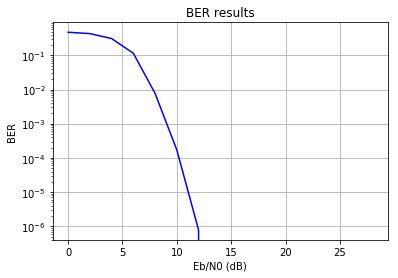

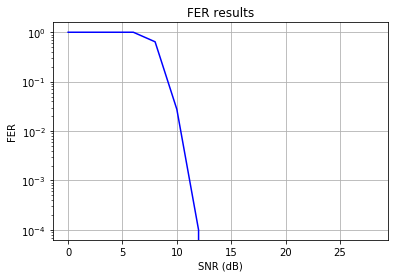

In [9]:
# Launch simulation
from MonteCarlo import *

# Model loading
model_path = "./models/pre_eq_model.pth"

simulation_param_dict = {
    "m_c_parameters": {
        "min_error_frame": 100,
        "targeted_fer": 1e-2,
        "step_db": 2,
        "min_eb_n0": 0,
        "max_eb_n0": 30,
    },
    "channel_parameters": {
        "channel_type": "AWGN",
        "non_lin_coeff": 0.5,
        "iq_imbalance": 0.5,
        "channel_taps": np.array([1]),
    },
    "frame_length": 256,
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "ZF",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
    "pre_equalizer": {
        "model_path": model_path,
        "feed_back_freq": 0,
    }
}

# Launch the simulation
monte_carlo_simulation(simulation_param_dict, "test")

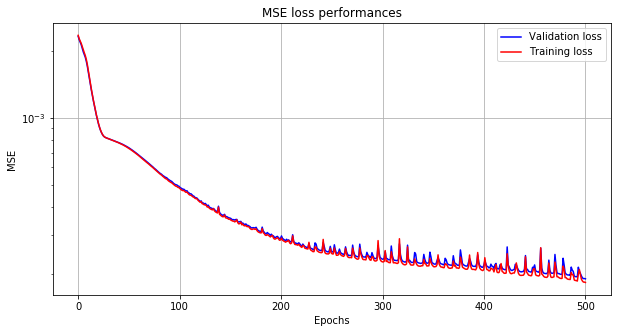

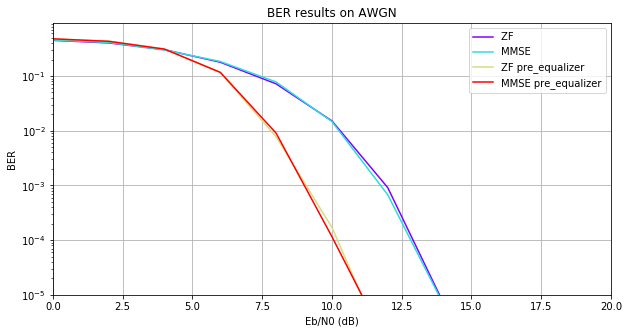

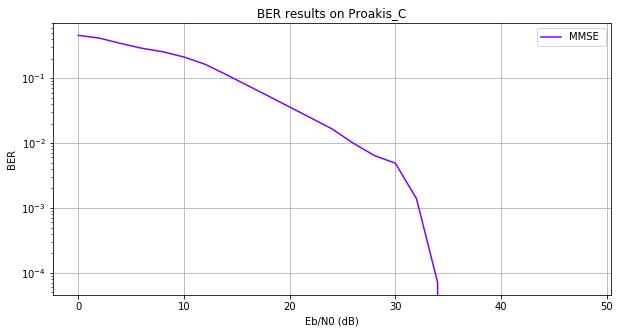

In [15]:
#  Print of performances
from Utils import *
import matplotlib2tikz

# Plot AWGN
res_MMSE = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_50_step_2_.pickle"
)
res_ZF = load_results(
    "./results/OFDM_eq_ZF_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_50_step_2_.pickle"
)
res_ZF_pre_eq = load_results(
    "./results/OFDM_eq_ZF_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_30_step_2_pre_equalizer_update_0.pickle"
)
res_MMSE_pre_eq = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_30_step_2_pre_equalizer_update_0.pickle"
)

# Load and training performances
output_path_training = "./results/pre_eq_model_train_AWGN.tex"
perf_epochs = load_results("./models/pre_eq_model_training_perf.pickle")
plot_training_performances(perf_epochs, output_path=output_path_training)

# Plot perfoamnces AWGN
output_path_performances = "./results/AWGN.tex"
plot_performance(
    [res_ZF, res_MMSE, res_ZF_pre_eq, res_MMSE_pre_eq],
    output_path=output_path_performances,
    max_eb_n0=20,
)

# Plot Proakis C
res_MMSE_pro = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0_iq_im_None_snr_0_to_50_step_2_.pickle"
)

plot_performance([res_MMSE_pro])